### Recycling Robot

In [11]:
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List

In [12]:
# ---------------- Config ----------------
GAMMA = 0.95
TD_LR = 0.1
EPOCHS = 10                # "several epochs"
STEPS_PER_EPOCH = 1000     # user request
NUM_RUNS = 3               # multiple trainings to average curves
EPSILON = 0.05             # small exploration for coverage

# Scenario grids (integers for r_search, r_wait; r_search > r_wait)
R_SEARCH_GRID = [4, 5, 6]
R_WAIT_GRID   = [1, 2, 3]
ALPHA_GRID    = [0.7, 0.8, 0.9]
BETA_GRID     = [0.5, 0.6, 0.7]

RESCUE_PENALTY = -3.0
START_STATE = 0  # start from High
BASE_SEED = 2025

In [13]:
# Files
REWARDS_PATH = "rewards.txt"           
SCENARIOS_SUMMARY = "scenario_summary.csv"  
BEST_JSON = "best_scenario.json"
REWARDS_FIG = "epoch_rewards_top.png"
POLICY_HEATMAP_FIG = "best_policy_heatmap.png"

# --------------- Environment ---------------
STATE_H, STATE_L = 0, 1
A_SEARCH, A_WAIT, A_RECHARGE = 0, 1, 2
STATE_NAMES = ["high", "low"]
ACTION_NAMES = ["search", "wait", "recharge"]


In [15]:
@dataclass
class Params:
    alpha: float
    beta: float
    r_search: int
    r_wait: int
    gamma: float
    rescue_penalty: float

def valid_actions(s: int) -> List[int]:
    return [A_SEARCH, A_WAIT] if s == STATE_H else [A_SEARCH, A_WAIT, A_RECHARGE]

def step_env(rng: np.random.Generator, s: int, a: int, p: Params) -> Tuple[int, float]:
    if s == STATE_H:
        if a == A_SEARCH:
            r = p.r_search
            s_next = STATE_H if rng.random() < p.alpha else STATE_L
            return s_next, r
        elif a == A_WAIT:
            return STATE_H, p.r_wait
        else:
            raise ValueError("Recharge invalid in HIGH")
    else:
        if a == A_SEARCH:
            if rng.random() < p.beta:
                return STATE_L, p.r_search
            else:
                return STATE_H, p.rescue_penalty
        elif a == A_WAIT:
            return STATE_L, p.r_wait
        elif a == A_RECHARGE:
            return STATE_H, 0.0
        else:
            raise ValueError("Unknown action")

def lookahead_q(s: int, a: int, V: np.ndarray, p: Params) -> float:
    g = p.gamma
    if s == STATE_H:
        if a == A_SEARCH:
            return p.r_search + g * (p.alpha * V[STATE_H] + (1 - p.alpha) * V[STATE_L])
        elif a == A_WAIT:
            return p.r_wait + g * V[STATE_H]
        else:
            return -np.inf
    else:
        if a == A_SEARCH:
            return p.beta * (p.r_search + g * V[STATE_L]) + (1 - p.beta) * (p.rescue_penalty + g * V[STATE_H])
        elif a == A_WAIT:
            return p.r_wait + g * V[STATE_L]
        elif a == A_RECHARGE:
            return 0.0 + g * V[STATE_H]

def greedy_policy_from_V(V: np.ndarray, p: Params) -> Dict[int, int]:
    pi = {}
    for s in [STATE_H, STATE_L]:
        valid = valid_actions(s)
        qvals = [lookahead_q(s, a, V, p) for a in valid]
        pi[s] = valid[int(np.argmax(qvals))]
    return pi

def td0_evaluate_policy(rng: np.random.Generator, p: Params, pi: Dict[int,int], V: np.ndarray, steps: int) -> float:
    """Run TD(0) for 'steps' under policy pi (with small ε exploration); return total reward this epoch."""
    total = 0.0
    s = START_STATE
    for _ in range(steps):
        valid = valid_actions(s)
        # ε-greedy around π to ensure coverage
        if rng.random() < EPSILON:
            a = rng.choice(valid)
        else:
            a = pi[s]
        s_next, r = step_env(rng, s, a, p)
        total += r
        td_target = r + p.gamma * V[s_next]
        V[s] += TD_LR * (td_target - V[s])
        s = s_next
    return total

def policy_to_transition_matrix(pi: Dict[int,int], p: Params) -> np.ndarray:
    """P_pi: 2x2 transition matrix induced by deterministic pi."""
    P = np.zeros((2,2), dtype=float)
    # from H
    a = pi[STATE_H]
    if a == A_SEARCH:
        P[STATE_H, STATE_H] = p.alpha
        P[STATE_H, STATE_L] = 1 - p.alpha
    elif a == A_WAIT:
        P[STATE_H, STATE_H] = 1.0
    else:
        raise ValueError("Invalid action at H in policy")
    # from L
    a = pi[STATE_L]
    if a == A_SEARCH:
        P[STATE_L, STATE_L] = p.beta
        P[STATE_L, STATE_H] = 1 - p.beta
    elif a == A_WAIT:
        P[STATE_L, STATE_L] = 1.0
    elif a == A_RECHARGE:
        P[STATE_L, STATE_H] = 1.0
    return P

def expected_reward_per_state(pi: Dict[int,int], p: Params) -> np.ndarray:
    """Immediate expected reward R_pi(s) under deterministic pi."""
    R = np.zeros(2, dtype=float)
    # H
    a = pi[STATE_H]
    if a == A_SEARCH:
        R[STATE_H] = p.r_search
    elif a == A_WAIT:
        R[STATE_H] = p.r_wait
    # L
    a = pi[STATE_L]
    if a == A_SEARCH:
        R[STATE_L] = p.beta * p.r_search + (1 - p.beta) * p.rescue_penalty
    elif a == A_WAIT:
        R[STATE_L] = p.r_wait
    elif a == A_RECHARGE:
        R[STATE_L] = 0.0
    return R

def stationary_distribution(P: np.ndarray) -> np.ndarray:
    """Compute stationary distribution for a 2x2 ergodic Markov chain P."""
    # Solve π^T P = π^T with sum(π)=1; for 2x2 we can do it analytically.
    # Use linear solve for generality.
    A = (P.T - np.eye(2))
    # Replace one equation with sum constraint
    A[0,:] = np.ones(2)
    b = np.array([1.0, 0.0])
    pi = np.linalg.lstsq(A, b, rcond=None)[0]
    return pi

def avg_reward_per_step(pi: Dict[int,int], p: Params) -> float:
    """Long-run average reward (steady-state), not discounted."""
    P = policy_to_transition_matrix(pi, p)
    R = expected_reward_per_state(pi, p)
    mu = stationary_distribution(P)
    return float(mu @ R)

def run_td_policy_iteration_for_scenario(scenario_id: int, p: Params, num_runs: int, epochs: int, steps_per_epoch: int, base_seed: int):
    """Return (mean_curve, std_curve, final_policy, avg_reward, all_rows_for_rewards_txt)."""
    curves = []
    rewards_rows = []
    final_policy = None
    for run in range(num_runs):
        rng = np.random.default_rng(base_seed + scenario_id*7919 + run*101)
        V = np.zeros(2, dtype=float)
        # Start from a simple policy (wait in both states if valid)
        pi = {STATE_H: A_WAIT, STATE_L: A_WAIT}
        per_epoch_totals = []
        for ep in range(1, epochs+1):
            total = td0_evaluate_policy(rng, p, pi, V, steps_per_epoch)
            per_epoch_totals.append(total)
            # Greedy improvement
            pi = greedy_policy_from_V(V, p)
            rewards_rows.append({
                "scenario": scenario_id,
                "run": run,
                "epoch": ep,
                "total_reward": total,
                "alpha": p.alpha,
                "beta": p.beta,
                "r_search": p.r_search,
                "r_wait": p.r_wait
            })
        curves.append(np.array(per_epoch_totals, dtype=float))
        final_policy = pi
    curves = np.vstack(curves)
    mean_curve = curves.mean(axis=0)
    std_curve = curves.std(axis=0)
    # Compute steady-state average reward for the final policy (using model)
    avg_r = avg_reward_per_step(final_policy, p)
    return mean_curve, std_curve, final_policy, avg_r, rewards_rows


In [16]:
# ----------------- Run all scenarios -----------------
# Prepare rewards.txt (overwrite with header)
with open(REWARDS_PATH, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["scenario","run","epoch","total_reward","alpha","beta","r_search","r_wait"])
    writer.writeheader()

scenario_records = []  # for summary CSV
scenario_id = 0
best = None

In [17]:
for rs in R_SEARCH_GRID:
    for rw in R_WAIT_GRID:
        if rs <= rw:
            continue
        for a in ALPHA_GRID:
            for b in BETA_GRID:
                p = Params(alpha=a, beta=b, r_search=rs, r_wait=rw, gamma=GAMMA, rescue_penalty=RESCUE_PENALTY)
                mean_curve, std_curve, final_pi, avg_r, rows = run_td_policy_iteration_for_scenario(
                    scenario_id, p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, BASE_SEED
                )
                # Append to rewards.txt
                with open(REWARDS_PATH, "a", newline="", encoding="utf-8") as f:
                    writer = csv.DictWriter(f, fieldnames=["scenario","run","epoch","total_reward","alpha","beta","r_search","r_wait"])
                    for r in rows:
                        writer.writerow(r)
                # Record scenario summary
                rec = {
                    "scenario": scenario_id,
                    "alpha": a, "beta": b, "r_search": rs, "r_wait": rw,
                    "avg_reward_per_step": avg_r,
                    "final_policy_H": ACTION_NAMES[final_pi[STATE_H]],
                    "final_policy_L": ACTION_NAMES[final_pi[STATE_L]],
                    "mean_curve": mean_curve.tolist(),
                    "std_curve": std_curve.tolist(),
                }
                scenario_records.append(rec)
                if (best is None) or (avg_r > best["avg_reward_per_step"]):
                    best = rec
                scenario_id += 1

In [18]:
# Save scenario summary CSV
with open(SCENARIOS_SUMMARY, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=[
        "scenario","alpha","beta","r_search","r_wait","avg_reward_per_step","final_policy_H","final_policy_L"
    ])
    writer.writeheader()
    for rec in scenario_records:
        writer.writerow({
            "scenario": rec["scenario"],
            "alpha": rec["alpha"],
            "beta": rec["beta"],
            "r_search": rec["r_search"],
            "r_wait": rec["r_wait"],
            "avg_reward_per_step": rec["avg_reward_per_step"],
            "final_policy_H": rec["final_policy_H"],
            "final_policy_L": rec["final_policy_L"],
        })

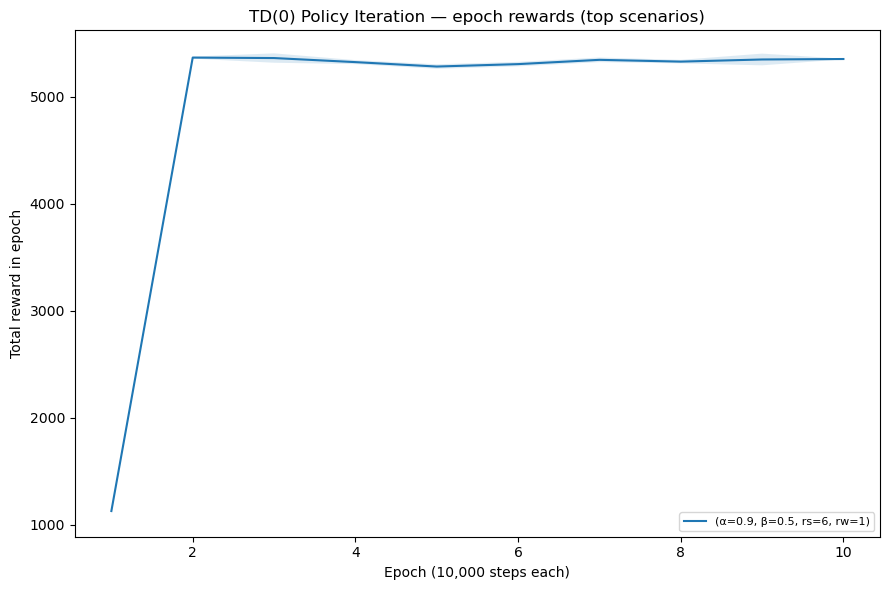

In [22]:
# Save best scenario JSON (includes mean/std curves for plotting and policy)
with open(BEST_JSON, "w", encoding="utf-8") as f:
    json.dump(best, f, indent=2)

# ----------------- Plots -----------------
# 1) Plot mean epoch curves for the top K scenarios by average reward to avoid clutter
TOP_K = 1
top_sorted = sorted(scenario_records, key=lambda r: r["avg_reward_per_step"], reverse=True)[:TOP_K]

plt.figure(figsize=(9,6))
x = np.arange(1, EPOCHS+1)
for rec in top_sorted:
    label = f"(α={rec['alpha']}, β={rec['beta']}, rs={rec['r_search']}, rw={rec['r_wait']})"
    mean = np.array(rec["mean_curve"])
    std = np.array(rec["std_curve"])
    plt.plot(x, mean, label=label)
    plt.fill_between(x, mean-std, mean+std, alpha=0.15)
plt.xlabel("Epoch (10,000 steps each)")
plt.ylabel("Total reward in epoch")
plt.title("TD(0) Policy Iteration — epoch rewards (top scenarios)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(REWARDS_FIG)
# plt.close()

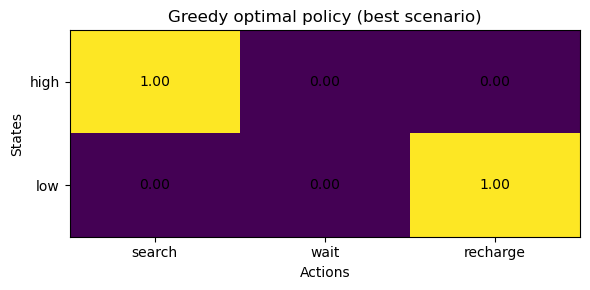

In [20]:
# 2) Policy heatmap for the best scenario (deterministic greedy -> one "1.0" per state)
policy_matrix = np.zeros((2,3), dtype=float)
policy_matrix[STATE_H, ACTION_NAMES.index(best["final_policy_H"])] = 1.0
policy_matrix[STATE_L, ACTION_NAMES.index(best["final_policy_L"])] = 1.0

fig = plt.figure(figsize=(6,3))
ax = plt.gca()
im = ax.imshow(policy_matrix, aspect="auto")
ax.set_xticks(np.arange(3)); ax.set_yticks(np.arange(2))
ax.set_xticklabels(ACTION_NAMES); ax.set_yticklabels(STATE_NAMES)
plt.xlabel("Actions"); plt.ylabel("States")
plt.title("Greedy optimal policy (best scenario)")
# annotate
for i in range(2):
    for j in range(3):
        txt = "1.00" if policy_matrix[i,j] == 1.0 else "0.00"
        ax.text(j, i, txt, ha="center", va="center")
plt.tight_layout()
plt.savefig(POLICY_HEATMAP_FIG)
# plt.close()


In [21]:
(
    REWARDS_PATH,
    SCENARIOS_SUMMARY,
    BEST_JSON,
    REWARDS_FIG,
    POLICY_HEATMAP_FIG,
    best,
)

('rewards.txt',
 'scenario_summary.csv',
 'best_scenario.json',
 'epoch_rewards_top.png',
 'best_policy_heatmap.png',
 {'scenario': 60,
  'alpha': 0.9,
  'beta': 0.5,
  'r_search': 6,
  'r_wait': 1,
  'avg_reward_per_step': 5.454545454545457,
  'final_policy_H': 'search',
  'final_policy_L': 'recharge',
  'mean_curve': [1126.0,
   5363.666666666667,
   5359.333333333333,
   5321.333333333333,
   5280.0,
   5302.666666666667,
   5342.666666666667,
   5326.0,
   5346.0,
   5350.333333333333],
  'std_curve': [24.99333244420733,
   9.877021593352703,
   43.926706632247715,
   18.62495339293199,
   21.18175315375634,
   21.139746660943903,
   21.483844059096022,
   16.57307052620807,
   54.7905101272109,
   3.0912061651652345]})